# Pendahuluan

--- Lebih dari 70% pengguna yang memasukkan produk ke keranjang akhirnya tidak menyelesaikan transaksi. Angka ini menunjukkan adanya celah besar antara ketertarikan awal dan keputusan akhir untuk membeli. Dalam konteks bisnis, setiap keranjang yang ditinggalkan adalah peluang yang hilang. Oleh karena itu, penting bagi platform e-commerce untuk dapat mengenali pola perilaku pengguna sejak dini, dan memprediksi siapa yang benar-benar berpotensi melakukan pembelian.

--- Melalui penelitian ini, kami bertujuan untuk membangun model prediktif yang mampu mengklasifikasikan kemungkinan konversi pengguna berdasarkan pola interaksi mereka di platform — seperti jenis aktivitas (view, cart, purchase), waktu akses (pagi, siang, malam), dan hari (weekday atau weekend). Hasil dari prediksi ini dapat dimanfaatkan sebagai dasar dalam pengambilan keputusan bisnis, seperti pemberian diskon yang lebih tepat sasaran, pengiriman notifikasi strategis, hingga pengembangan sistem rekomendasi yang lebih akurat.

In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [2]:
# connect gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# open dataset

df = pd.read_csv('/content/drive/MyDrive/Take Home Test/dataset.csv')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


## Data Understanding

In [4]:
# struktur data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [5]:
# cek missing value

df.isnull().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,236219
brand,212364
price,0
user_id,0
user_session,165


In [6]:
# hitung data null dalam persen

df.isnull().sum() / len(df) * 100

,0
event_time,0.000000
event_type,0.000000
product_id,0.000000
category_id,0.000000
category_code,26.687522
brand,23.992435
price,0.000000
user_id,0.000000
user_session,0.018641


data null

 - 26.6% pada category_code
 - 23.9% pada brand
 - 1.8% persen pada user-session

In [7]:
# check duplicate

df.duplicated().sum()

np.int64(655)

In [8]:
# hitung duplicate dalam persen

df.duplicated().sum() / len(df) * 100

np.float64(0.07400051291958573)

Terdapat 7.4 persen data duplicate

In [9]:
# describe

df.describe()

,product_id,category_id,price,user_id
count,8.851290e+05,8.851290e+05,885129.000000,8.851290e+05
mean,1.906621e+06,2.144423e+18,146.328713,1.515916e+18
std,1.458708e+06,6.165105e+14,296.807683,3.747287e+07
min,1.020000e+02,2.144416e+18,0.220000,1.515916e+18
25%,6.988030e+05,2.144416e+18,26.460000,1.515916e+18
50%,1.452883e+06,2.144416e+18,65.710000,1.515916e+18
75%,3.721194e+06,2.144416e+18,190.490000,1.515916e+18
max,4.183880e+06,2.227847e+18,64771.060000,1.515916e+18


In [9]:
# count event_type

df['event_type'].value_counts()

,count
event_type,
view,793748
cart,54035
purchase,37346


In [58]:
# hitung value count menjadi presentase

df['event_type'].value_counts(normalize=True)

,proportion
event_type,
view,0.896760
cart,0.061048
purchase,0.042193


In [10]:
# count product_id

df['product_id'].value_counts()

,count
product_id,
1821813,14563
4099645,7089
3791351,6907
3829355,5762
1785245,5118
...,...
381832,1
3791036,1
589832,1


In [11]:
# hitung product_id unic

df['product_id'].nunique()

53453

In [12]:
# count user_id

df['user_id'].value_counts()

,count
user_id,
1515915625554995474,572
1515915625527763086,424
1515915625591251010,363
1515915625591659523,339
1515915625537803839,329
...,...
1515915625541762272,1
1515915625541762044,1
1515915625541761930,1


In [13]:
# hitung user_id unic

df['user_id'].nunique()

407283

**Eda Awal**

- melihat distribusi waktu dengan event_type
- category_code dengan waktu

**Distribusi waktu dengan event**

In [10]:
# copy dataset

data = df.copy()

In [11]:
# hapus utc pada event_time

data['event_time'] = data['event_time'].str.replace(' UTC', '')

# ganti type datanya

data['event_time'] = pd.to_datetime(data['event_time'])


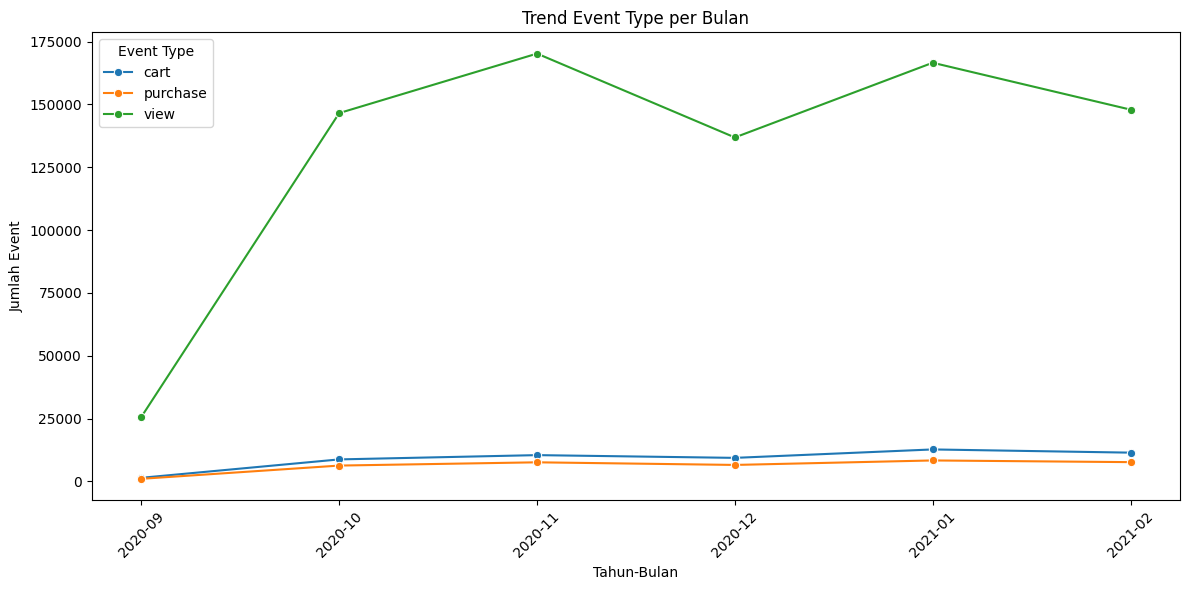

In [12]:
# kolom year month

data['year_month'] = data['event_time'].dt.to_period('M').astype(str)

# jumlah event perbulan

monthly_counts = data.groupby(['year_month', 'event_type']).size().reset_index(name='count')

# plot

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='year_month', y='count', hue='event_type', marker='o')

plt.xlabel('Tahun-Bulan')
plt.ylabel('Jumlah Event')
plt.title('Trend Event Type per Bulan')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

In [17]:
data.tail()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year_month
885124,2021-02-28 23:55:01,view,953226,2144415927553229037,NaN,NaN,219.94,1515915625611023730,FRLqIttxKU,2021-02
885125,2021-02-28 23:58:05,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma,2021-02
885126,2021-02-28 23:58:09,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd,2021-02
885127,2021-02-28 23:58:14,view,888273,2144415921932861531,electronics.telephone,NaN,10.16,1515915625611024030,9pCbKMIcSx,2021-02
885128,2021-02-28 23:59:09,view,743182,2144415935631458761,construction.tools.soldering,kada,65.08,1515915625556087775,BejOXRngEW,2021-02


# Data Preparation

**Data Cleaning**

In [13]:
# cek duplicate

data.duplicated().sum()

np.int64(655)

In [14]:
# hapus duplicate

data.drop_duplicates(inplace=True)

In [15]:
# event_time jadikan tahun, bulan, hari dan jam

data['year'] = data['event_time'].dt.year
data['month'] = data['event_time'].dt.month
data['day'] = data['event_time'].dt.day

# hour hingga menit 0-24

data['hour'] = data['event_time'].dt.hour

In [16]:
# pisahkan category_code menjadi main_category dan sub_category

data[['main_category', 'sub_category']] = data['category_code'].str.split('.', n=1, expand=True)

In [17]:
# kolom mingguan

# Buat kolom baru 'day_type'
data['day_type'] = data['event_time'].dt.dayofweek.apply(lambda x: 'weekend' if x >= 5 else 'weekday')

In [18]:
# data hour

data['hour'].value_counts()

,count
hour,
11,53568
10,53014
9,52516
12,52466
17,51726
13,50785
18,50551
16,49965
8,49908


In [19]:
# Buat kolom time_period berdasarkan jam
def get_time_period(hour):
    if 5 <= hour <= 10:
        return 'pagi'
    elif 11 <= hour <= 14:
        return 'siang'
    elif 15 <= hour <= 18:
        return 'sore'
    else:
        return 'malam'

data['time_period'] = data['hour'].apply(get_time_period)

In [61]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year_month,year,month,day,hour,main_category,sub_category,day_type,time_period
0,2020-09-24 11:57:06,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT,2020-09,2020,9,24,11,electronics,telephone,weekday,siang
1,2020-09-24 11:57:26,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2020-09,2020,9,24,11,computers,components.cooler,weekday,siang
2,2020-09-24 11:57:27,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy,2020-09,2020,9,24,11,NaN,NaN,weekday,siang
3,2020-09-24 11:57:33,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2020-09,2020,9,24,11,computers,peripherals.printer,weekday,siang
4,2020-09-24 11:57:36,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,2020-09,2020,9,24,11,NaN,NaN,weekday,siang


In [20]:
# save dataset

data.to_csv('data_clean.csv', index=False)

In [21]:
# main category unique

data['main_category'].unique()

array(['electronics', 'computers', nan, 'construction', 'auto',
       'appliances', 'stationery', 'furniture', 'kids', 'accessories',
       'country_yard', 'apparel', 'medicine', 'sport', 'jewelry'],
      dtype=object)

In [22]:
# hitung value

data['main_category'].value_counts()

,count
main_category,
computers,316709
electronics,170989
stationery,42956
appliances,41054
auto,35410
construction,31045
furniture,3364
country_yard,3137
accessories,2075


In [23]:
missing = data.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
print(missing_df)

               Missing    Percent
sub_category    236047  26.687839
category_code   236047  26.687839
main_category   236047  26.687839
brand           212232  23.995279
user_session       162   0.018316
event_time           0   0.000000
event_type           0   0.000000
price                0   0.000000
product_id           0   0.000000
category_id          0   0.000000
year_month           0   0.000000
user_id              0   0.000000
year                 0   0.000000
month                0   0.000000
hour                 0   0.000000
day                  0   0.000000
day_type             0   0.000000
time_period          0   0.000000


In [ ]:
# nan imputasi menjadi unknown

data['main_category'].fillna('unknown', inplace=True)
data['sub_category'].fillna('unknown', inplace=True)


In [26]:
# buatkan dataframe untuk 2kolom yang memperlihatkan nilai uniknya saja, kolom day_type dan time_period

unique_day_type = data['day_type'].unique()
unique_time_period = data['time_period'].unique()

unique_day_type_df = pd.DataFrame({'day_type': unique_day_type})
unique_time_period_df = pd.DataFrame({'time_period': unique_time_period})

# gabungkan

unique_df = pd.concat([unique_day_type_df, unique_time_period_df], axis=1)
unique_df.head()

,day_type,time_period
0,weekday,siang
1,weekend,sore
2,NaN,malam
3,NaN,pagi


In [24]:
data_copy = data.copy()

In [25]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 884474 entries, 0 to 885128
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_time     884474 non-null  datetime64[ns]
 1   event_type     884474 non-null  object        
 2   product_id     884474 non-null  int64         
 3   category_id    884474 non-null  int64         
 4   category_code  648427 non-null  object        
 5   brand          672242 non-null  object        
 6   price          884474 non-null  float64       
 7   user_id        884474 non-null  int64         
 8   user_session   884312 non-null  object        
 9   year_month     884474 non-null  object        
 10  year           884474 non-null  int32         
 11  month          884474 non-null  int32         
 12  day            884474 non-null  int32         
 13  hour           884474 non-null  int32         
 14  main_category  648427 non-null  object        
 15  sub_c

In [27]:
data_model = data_copy[['user_id','day_type', 'time_period','event_type']]
data_model.head()

,user_id,day_type,time_period,event_type
0,1515915625519388267,weekday,siang,view
1,1515915625519380411,weekday,siang,view
2,1515915625513238515,weekday,siang,view
3,1515915625519014356,weekday,siang,view
4,1515915625510743344,weekday,siang,view


In [28]:
data_fix = pd.get_dummies(data_model, columns=['day_type', 'time_period'])
data_fix.head()

,user_id,event_type,day_type_weekday,day_type_weekend,time_period_malam,time_period_pagi,time_period_siang,time_period_sore
0,1515915625519388267,view,True,False,False,False,True,False
1,1515915625519380411,view,True,False,False,False,True,False
2,1515915625513238515,view,True,False,False,False,True,False
3,1515915625519014356,view,True,False,False,False,True,False
4,1515915625510743344,view,True,False,False,False,True,False


In [29]:
# Hitung jumlah event_type per user
event_pivot = data_fix.pivot_table(
    index='user_id',
    columns='event_type',
    values='day_type_weekday',  # bisa pakai kolom apa saja asal ada
    aggfunc='count',
    fill_value=0
).reset_index()

event_pivot.head()

event_type,user_id,cart,purchase,view
0,1515915625353226922,0,0,1
1,1515915625353230067,0,0,1
2,1515915625353230683,0,0,13
3,1515915625353230922,0,0,1
4,1515915625353234047,0,0,36


In [30]:
# Agregasi fitur waktu
time_features = data_fix.groupby('user_id').agg({
    col: 'sum' for col in data_fix.columns if col.startswith('day_type_') or col.startswith('time_period_')
}).reset_index()

time_features.head()

,user_id,day_type_weekday,day_type_weekend,time_period_malam,time_period_pagi,time_period_siang,time_period_sore
0,1515915625353226922,1,0,0,0,1,0
1,1515915625353230067,1,0,0,1,0,0
2,1515915625353230683,12,1,0,13,0,0
3,1515915625353230922,1,0,0,1,0,0
4,1515915625353234047,28,8,0,32,0,4


In [31]:
# Gabungkan pivot event_type dan fitur waktu
features = event_pivot.merge(time_features, on='user_id', how='left')

# Buat label target: 1 jika pernah purchase, 0 jika tidak
features['made_purchase'] = (features.get('purchase', 0) > 0).astype(int)

features.head()

,user_id,cart,purchase,view,day_type_weekday,day_type_weekend,time_period_malam,time_period_pagi,time_period_siang,time_period_sore,made_purchase
0,1515915625353226922,0,0,1,1,0,0,0,1,0,0
1,1515915625353230067,0,0,1,1,0,0,1,0,0,0
2,1515915625353230683,0,0,13,12,1,0,13,0,0,0
3,1515915625353230922,0,0,1,1,0,0,1,0,0,0
4,1515915625353234047,0,0,36,28,8,0,32,0,4,0


In [37]:
features.describe()

,user_id,cart,purchase,view,day_type_weekday,day_type_weekend,time_period_malam,time_period_pagi,time_period_siang,time_period_sore,made_purchase
count,4.072830e+05,407283.000000,407283.000000,407283.000000,407283.000000,407283.000000,407283.000000,407283.000000,407283.000000,407283.000000,407283.000000
mean,1.515916e+18,0.132665,0.091688,1.947292,1.580483,0.591161,0.505229,0.667074,0.506081,0.493261,0.052308
std,3.358013e+07,0.672434,0.557701,3.816546,3.567077,1.987655,1.862871,2.172563,1.600684,1.662972,0.222647
min,1.515916e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.515916e+18,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.515916e+18,91.000000,56.000000,572.000000,572.000000,260.000000,230.000000,569.000000,124.000000,135.000000,1.000000


In [34]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407283 entries, 0 to 407282
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   user_id            407283 non-null  int64
 1   cart               407283 non-null  int64
 2   purchase           407283 non-null  int64
 3   view               407283 non-null  int64
 4   day_type_weekday   407283 non-null  int64
 5   day_type_weekend   407283 non-null  int64
 6   time_period_malam  407283 non-null  int64
 7   time_period_pagi   407283 non-null  int64
 8   time_period_siang  407283 non-null  int64
 9   time_period_sore   407283 non-null  int64
 10  made_purchase      407283 non-null  int64
dtypes: int64(11)
memory usage: 34.2 MB


# EDA

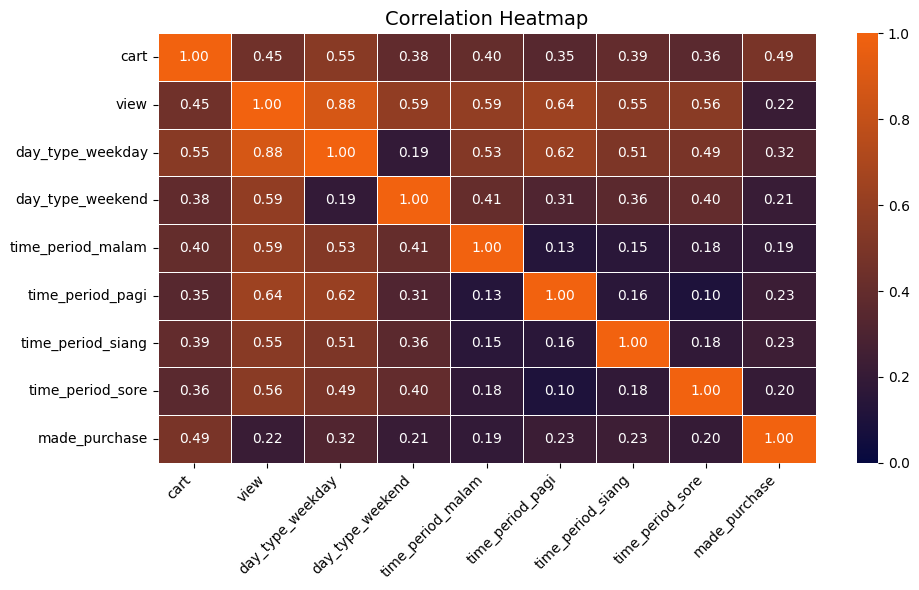

In [39]:
from matplotlib.colors import LinearSegmentedColormap
# melihat korelasi dari features berdasarkan made-purchase dan drop user_id dan purchase

# Drop kolom yang tidak perlu
df_corr = features.drop(columns=['user_id', 'purchase'])

# Hitung korelasi antar semua fitur
correlation = df_corr.corr()

# Buat custom colormap dari #060940 ke #F2620F
colors = ["#060940", "#F2620F"]
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)

# Buat heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            vmin=0.0, vmax=1.0,
            linewidths=0.5,
            cbar=True)

plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
# hitung persentase tiap event_type berdasarkan day_type

event_counts = data_copy.groupby(['day_type', 'event_type']).size().reset_index(name='count')

# Hitung total event per day_type
total_per_day = event_counts.groupby('day_type')['count'].transform('sum')

# Tambahkan kolom persentase
event_counts['percentage'] = (event_counts['count'] / total_per_day) * 100

# Bulatkan hasil untuk tampilan
event_counts['percentage'] = event_counts['percentage'].round(2)

print(event_counts)

  day_type event_type   count  percentage
0  weekday       cart   39586        6.15
1  weekday   purchase   27352        4.25
2  weekday       view  576766       89.60
3  weekend       cart   14446        6.00
4  weekend   purchase    9991        4.15
5  weekend       view  216333       89.85


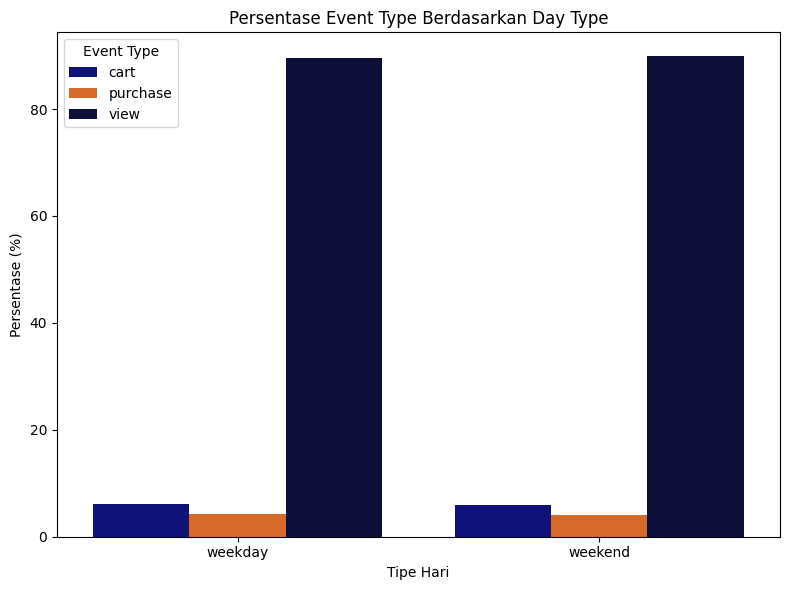

In [42]:
# buat grafik

event_colors = {
    'purchase': '#F2620F',
    'view': '#060940',
    'cart': 'darkblue'
}

# Buat barplot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=event_counts,
    x='day_type',
    y='percentage',
    hue='event_type',
    palette=event_colors
)

# Tambahkan label dan judul
plt.title('Persentase Event Type Berdasarkan Day Type')
plt.xlabel('Tipe Hari')
plt.ylabel('Persentase (%)')
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()


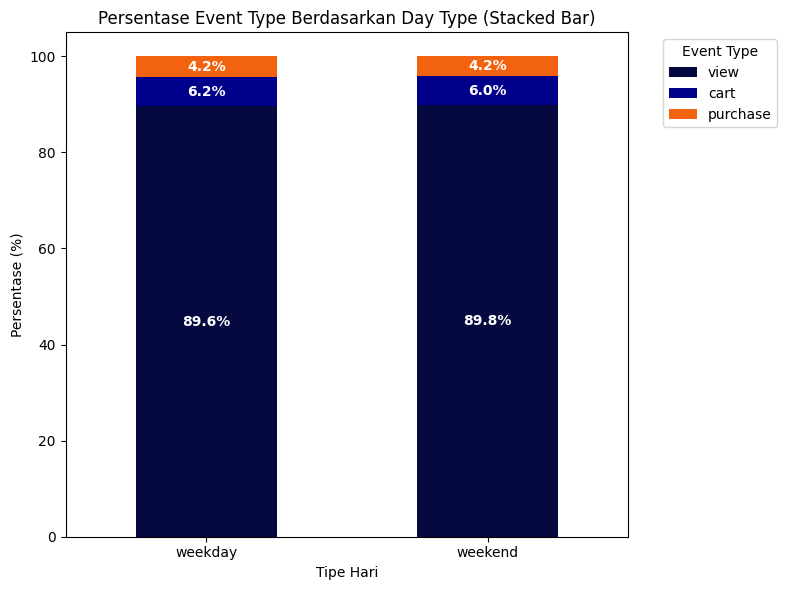

In [43]:
# Pivot data agar bisa distack
pivot_df = event_counts.pivot(index='day_type', columns='event_type', values='percentage')

# Urutkan event agar warnanya sesuai
pivot_df = pivot_df[['view', 'cart', 'purchase']]

# Warna sesuai permintaan
colors = {
    'view': '#060940',
    'cart': 'darkblue',
    'purchase': '#F2620F'
}

# Plot stacked bar chart
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    color=[colors[col] for col in pivot_df.columns],
    figsize=(8, 6)
)

# Tambahkan label persentase di tengah setiap segmen
for idx, day_type in enumerate(pivot_df.index):
    cumulative = 0
    for event_type in pivot_df.columns:
        percentage = pivot_df.loc[day_type, event_type]
        if percentage > 0:
            ax.text(
                idx,
                cumulative + (percentage / 2),
                f'{percentage:.1f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=10,
                fontweight='bold'
            )
            cumulative += percentage

# Label dan judul
plt.title('Persentase Event Type Berdasarkan Day Type (Stacked Bar)')
plt.xlabel('Tipe Hari')
plt.ylabel('Persentase (%)')
plt.xticks(rotation=0)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Model

In [45]:
from sklearn.model_selection import train_test_split

X = features.drop(columns=['user_id', 'made_purchase', 'purchase'])
y = features['made_purchase']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [46]:
# smote

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [47]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [43]:
# terapkan pada data train

from sklearn.metrics import classification_report, roc_auc_score

y_pred_train = model.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_pred_train))
print("ROC-AUC:", roc_auc_score(y_train_resampled, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    270185
           1       1.00      1.00      1.00    270185

    accuracy                           1.00    540370
   macro avg       1.00      1.00      1.00    540370
weighted avg       1.00      1.00      1.00    540370

ROC-AUC: 0.999901919055462


In [44]:
# terapkan pada datatest

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    115794
           1       0.90      0.98      0.94      6391

    accuracy                           0.99    122185
   macro avg       0.95      0.99      0.97    122185
weighted avg       0.99      0.99      0.99    122185

ROC-AUC: 0.9994072153888163


In [45]:
print(y.value_counts(normalize=True))

made_purchase
0    0.947692
1    0.052308
Name: proportion, dtype: float64


<ipython-input-48-566e7c635b23>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance, y=feat_importance.index, palette=bar_colors)


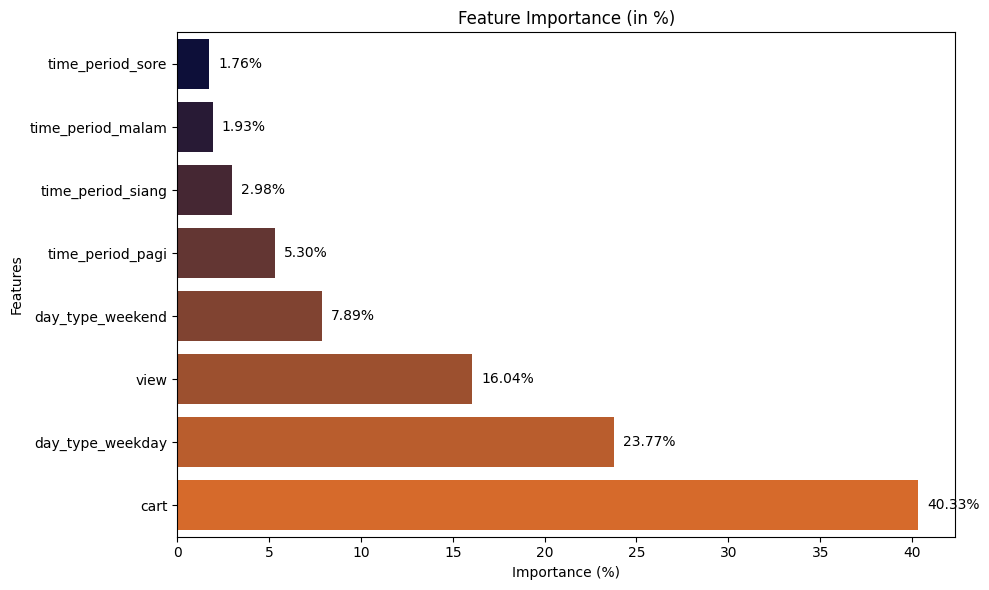

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung feature importance dalam persentase
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
feat_importance = feat_importance.sort_values(ascending=True) * 100  # sort dan ubah ke persen

# # Plot horizontal bar chart
# plt.figure(figsize=(10, 6))
# sns.barplot(x=feat_importance, y=feat_importance.index, palette='viridis')

# # Tambahkan nilai persentase di ujung bar
# for i, v in enumerate(feat_importance):
#     plt.text(v + 0.5, i, f"{v:.2f}%", va='center')

# plt.title("Feature Importance (in %)")
# plt.xlabel("Importance (%)")
# plt.ylabel("Features")
# plt.tight_layout()
# plt.show()


# Buat gradasi warna dari #060940 ke #F2620F
colors = [ "#060940", "#F2620F" ]
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=len(feat_importance))

# Buat warna sesuai jumlah fitur
bar_colors = [custom_cmap(i / len(feat_importance)) for i in range(len(feat_importance))]

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance, y=feat_importance.index, palette=bar_colors)

# Tambahkan nilai persentase di ujung bar
for i, v in enumerate(feat_importance):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')

plt.title("Feature Importance (in %)")
plt.xlabel("Importance (%)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


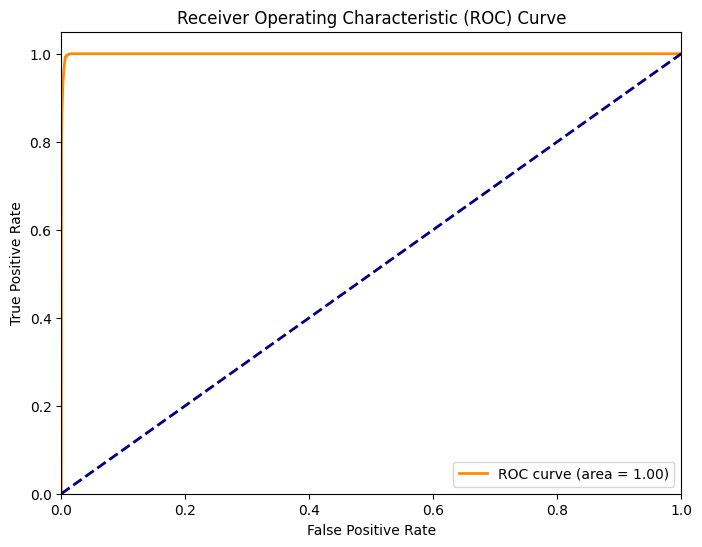

In [47]:
# check overfiting

from sklearn.metrics import roc_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(
    y_test
    , y_pred_proba))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Kurva ROC-nya sangat dekat dengan titik (0, 1) — artinya model memiliki True Positive Rate (TPR) tinggi dan False Positive Rate (FPR) sangat rendah di hampir semua threshold.

- Area Under Curve (AUC) = 1.00 — ini adalah nilai maksimum. Artinya:

    --- Model memisahkan kelas positif dan negatif dengan sempurna pada data yang diuji.

    --- Tidak ada kesalahan klasifikasi pada threshold optimal.

In [48]:
# melihat auc scorenya

y_train_proba = model.predict_proba(X_train_resampled)[:, 1]
train_auc = roc_auc_score(y_train_resampled, y_train_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Train AUC: {train_auc:.2f}")
print(f"Test AUC: {test_auc:.2f}")


Train AUC: 1.00
Test AUC: 1.00


In [49]:
# check overfiting dengan cv-score

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Cross-Validation Scores: {cv_scores}")

Cross-Validation Scores: [0.9998542  0.9998691  0.9999137  0.99982683 0.999933  ]


In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier # Pastikan model diimpor jika belum

# Asumsikan model sudah dilatih sebelumnya dan X_train_resampled tersedia
# Contoh: model = RandomForestClassifier(random_state=42).fit(X_train_resampled, y_train_resampled)
# Pastikan Anda memiliki objek model dan X_train_resampled dari sel-sel sebelumnya

# Contoh input user (ganti sesuai kondisi yang ingin diuji)
input_data = {
    'cart': 23,
    'view': 10,
    'day_type_weekday': 33,
    'day_type_weekend': 76,
    'time_period_pagi': 70,
    'time_period_siang': 43,
    'time_period_sore': 90,
    'time_period_malam': 86
}

# Convert ke DataFrame
input_df = pd.DataFrame([input_data])

# Ambil urutan kolom dari data training
# Pastikan X_train_resampled masih ada di lingkungan Anda
training_columns = X_train_resampled.columns

# Reorder kolom input_df agar sesuai dengan training_columns
input_df = input_df[training_columns]

# Prediksi menggunakan model yang sudah dilatih
purchase_pred = model.predict(input_df)[0]
purchase_proba = model.predict_proba(input_df)[0][1]  # probabilitas untuk kelas 1

# Tampilkan hasil
print(f"Prediksi Purchase: {purchase_pred} (0=tidak, 1=ya)")
print(f"Probabilitas Purchase: {purchase_proba:.2f}")

Prediksi Purchase: 1 (0=tidak, 1=ya)
Probabilitas Purchase: 0.55


In [57]:
# simpan model

import joblib

joblib.dump(model, 'model_rf.joblib')

['model_rf.joblib']